In [574]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

main_folder = Path('.')

# Make an empty list to store dataframes
all_dataframes = []

# Loop through all subfolders within the main folder
for subfolder in main_folder.iterdir():
    if subfolder.is_dir():
        # Loop through all CSV files within the subfolder
        for csv_file in subfolder.glob('*.csv'):  # Find all CSV files in the folder
            try:
                # Load each CSV file into a pandas dataframe
                df = pd.read_csv(csv_file, encoding='ISO-8859-1', skiprows=7)
            except Exception as e:
                print(f"Error reading {csv_file}: {e}") # Skip to the next file if there's an error
                continue 

            # Add the folder/file name as columns to the dataframe for reference
            df['source_folder'] = subfolder.name
            df['source_file'] = csv_file.name
            
            # Append the dataframe to the list
            all_dataframes.append(df)

# Concatenate all the dataframes into one dataframe
combined_df = pd.concat(all_dataframes, ignore_index=True)

print(combined_df)

      Sample  Frequency(Hz)  Magnitude(dB)  Phase(°) source_folder  \
0          0        1000.00        38.8040  176.9010       100Gain   
1          1        1040.10        38.5560  173.9970       100Gain   
2          2        1081.81        38.5015  174.3030       100Gain   
3          3        1125.19        38.6279  173.9380       100Gain   
4          4        1170.31        38.6392  173.6400       100Gain   
...      ...            ...            ...       ...           ...   
7595     195    22064300.00        27.8870  -94.8243       LMH6624   
7596     196    22764200.00        27.7113  -97.6476       LMH6624   
7597     197    23486300.00        27.6559  -96.1466       LMH6624   
7598     198    24231300.00        27.6687 -101.7710       LMH6624   
7599     199    25000000.00        27.4902  -96.5193       LMH6624   

                source_file  
0       Run1_20mV_Input.csv  
1       Run1_20mV_Input.csv  
2       Run1_20mV_Input.csv  
3       Run1_20mV_Input.csv  
4       R

In [575]:
# Function to filter out input spikes
def remove_input_spike(df, threshold=1.5):
    clean_df = df.copy()
    
    # Loop through the first 10 rows and compare the current Magnitude with the next
    for i in range(min(10, len(clean_df) - 1)):
        current_magnitude = clean_df['Magnitude(dB)'].iloc[i]
        next_magnitude = clean_df['Magnitude(dB)'].iloc[i + 1]
        
        if current_magnitude > next_magnitude * threshold:
            clean_df = clean_df.drop(clean_df.index[i])
    
    return clean_df

In [576]:
# Function to filter plot data by source_folder and source_file, and optionally filter out input spikes
def select_data(df, source_folder, source_file, raw):
    # Filter by folder and file
    plot_data_raw = df[(df['source_folder'] == source_folder) & (df['source_file'] == source_file)]
    
    # Default to plotting raw data
    if raw:
        return plot_data_raw
    
    # Filter out input spike
    return remove_input_spike(plot_data_raw)

In [577]:
#Function for finding -3dB
def find_cutoff(df, samples_to_average):
    avg_gain= np.mean(df['Magnitude(dB)'][:samples_to_average])
    print(f'len df[Magnitude(dB)]:{len(df['Magnitude(dB)'])}')
    idx = next(x for x, val in enumerate(df['Magnitude(dB)']) if val < (avg_gain - 2.99))
    print(f'idx: {idx}')
    return idx

In [578]:
# Plot Frequency (Hz) vs Magnitude (dB)
def plot_frequency_vs_magnitude(df, source_folder, source_file, raw):
    plot_data = select_data(df, source_folder, source_file, raw)
    
    idx = find_cutoff(plot_data, 50)
    

    plt.figure(figsize=(8, 6))
    
    plt.plot(plot_data['Frequency(Hz)'], plot_data['Magnitude(dB)'], label=f'{source_folder}/{source_file}')

    
    plt.xscale('log')
    plt.xlabel('Frequency (Hz) [log scale]')
    plt.ylabel('Magnitude (dB)')
    plt.title(f'Frequency vs Magnitude for {source_folder}/{source_file}')
    plt.grid(True, which="major", ls="--")
    plt.legend()

    frequency_kenneth = plot_data['Frequency(Hz)'].iloc[100]
    print(f'frequency_kenneth: {frequency_kenneth}')
    print(plot_data['Frequency(Hz)'])
    plt.axvline(x=frequency_kenneth)

    plt.show()

In [579]:
# Plot Frequency (Hz) vs Phase (°)
def plot_frequency_vs_phase(df, source_folder, source_file, raw):
    plot_data = select_data(df, source_folder, source_file, raw)
    
    plt.figure(figsize=(8, 6))
    
    plt.plot(plot_data['Frequency(Hz)'], plot_data['Phase(°)'], label=f'{source_folder}/{source_file}')
    
    plt.xscale('log')
    plt.xlabel('Frequency (Hz) [log scale]')
    plt.ylabel('Phase(°)')
    plt.title(f'Frequency vs Phase for {source_folder}/{source_file}')
    plt.grid(True, which="major", ls="--")
    plt.legend()
    plt.show()

In [580]:
# Plot Frequency (Hz) vs Magnitude (dB), Phase (°)
def plot_frequency_vs_magnitude_phase(df, source_folder, source_file, raw):
    plot_data = select_data(df, source_folder, source_file, raw)

    fig, ax1 = plt.subplots(layout='constrained')

    color = 'tab:blue'
    ax1.set_xlabel('Frequency (Hz) [log scale]')
    ax1.set_xscale('log')
    ax1.set_ylabel('Magnitude (dB)', color=color)
    ax1.plot(plot_data['Frequency(Hz)'], plot_data['Magnitude(dB)'], color=color, label=f'{source_folder}/{source_file}')
    ax1.tick_params(axis='y', labelcolor=color)

    color = 'tab:red'
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('Phase(°)', color=color)  # we already handled the x-label with ax1
    ax2.plot(plot_data['Frequency(Hz)'], plot_data['Phase(°)'], color=color, label=f'{source_folder}/{source_file}')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title(f'Frequency vs Magnitude(dB) and Phase(°) for {source_folder}/{source_file}')
#    plt.grid(True, which="major", ls="--")
    plt.legend()
    plt.show()

len df[Magnitude(dB)]:200
idx: 129
len_freq: 50992.6
1800       1000.00
1801       1040.10
1802       1081.81
1803       1125.19
1804       1170.31
           ...    
1995    2136190.00
1996    2221850.00
1997    2310950.00
1998    2403620.00
1999    2500000.00
Name: Frequency(Hz), Length: 200, dtype: float64


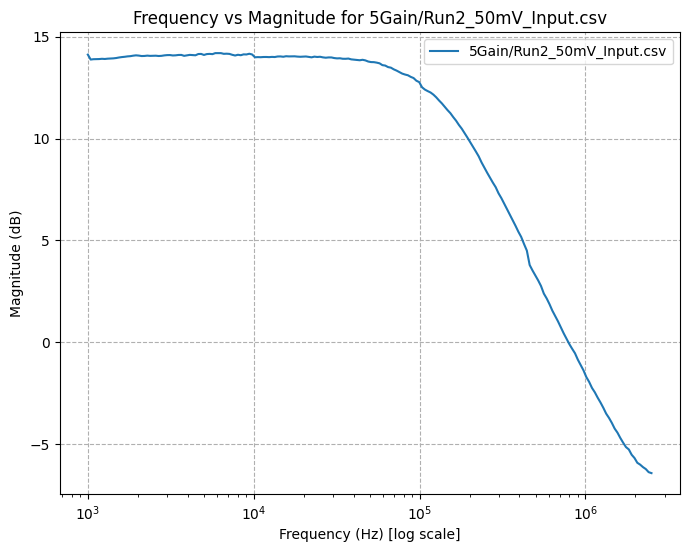

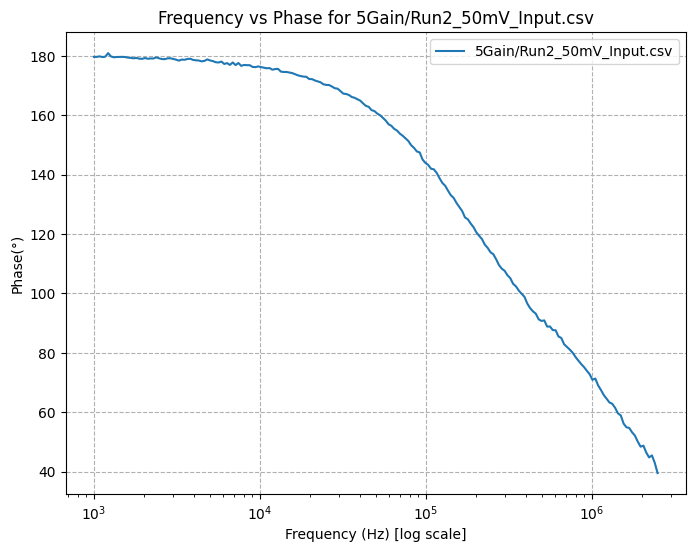

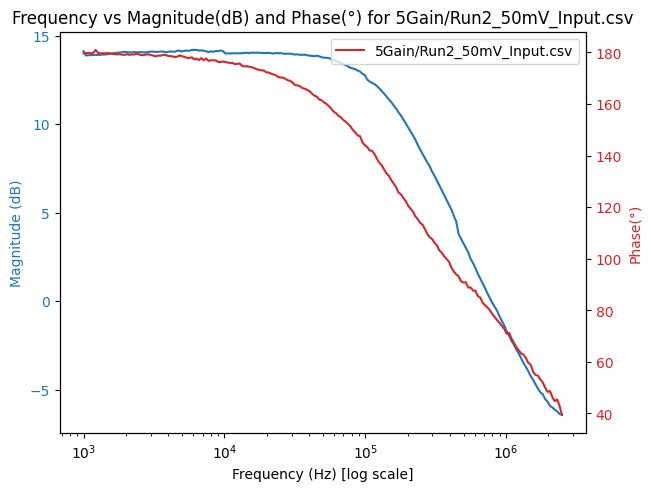

In [581]:
# Pick dataset
source_folder_to_plot = '5Gain'  # Replace with folder name
source_file_to_plot = 'Run2_50mV_Input.csv'  # Replace with file name
raw = False

# Call the plot functions for the specific folder and file
plot_frequency_vs_magnitude(combined_df, source_folder_to_plot, source_file_to_plot, raw)
plot_frequency_vs_phase(combined_df, source_folder_to_plot, source_file_to_plot, raw)
plot_frequency_vs_magnitude_phase(combined_df, source_folder_to_plot, source_file_to_plot, raw)


In [582]:
# Plot Frequency (Hz) vs Magnitude (dB) for all files in a folder
def plot_all_files_magnitude(df, source_folder, raw):
    plt.figure(figsize=(8, 6))
    
    # Filter by EB folder
    folder_data = df[df['source_folder'] == source_folder]
    files_in_folder = folder_data['source_file'].unique()
    
    # Loop through each file and plot its data
    for source_file in files_in_folder:
        plot_data = select_data(df, source_folder, source_file, raw)
        plt.plot(plot_data['Frequency(Hz)'], plot_data['Magnitude(dB)'], label=source_file)
    
    plt.xscale('log')
    plt.xlabel('Frequency (Hz) [log scale]')
    plt.ylabel('Magnitude (dB)')
    plt.title(f'Frequency vs Magnitude for All Files in {source_folder}')
    plt.grid(True, which="major", ls="--")
    plt.legend()
    plt.show()

In [583]:
# Plot Frequency (Hz) vs Phase (°) for all files in a folder
def plot_all_files_phase(df, source_folder, raw):
    plt.figure(figsize=(8, 6))
    
    # Filter by EB folder
    folder_data = df[df['source_folder'] == source_folder]
    files_in_folder = folder_data['source_file'].unique()
    
    # Loop through each file and plot its data
    for source_file in files_in_folder:
        plot_data = select_data(df, source_folder, source_file, raw)
        plt.plot(plot_data['Frequency(Hz)'], plot_data['Phase(°)'], label=source_file)
    
    plt.xscale('log')
    plt.xlabel('Frequency (Hz) [log scale]')
    plt.ylabel('Phase (degree)')
    plt.title(f'Frequency vs Phase for All Files in {source_folder}')
    plt.grid(True, which="major", ls="--")
    plt.legend()
    plt.show()

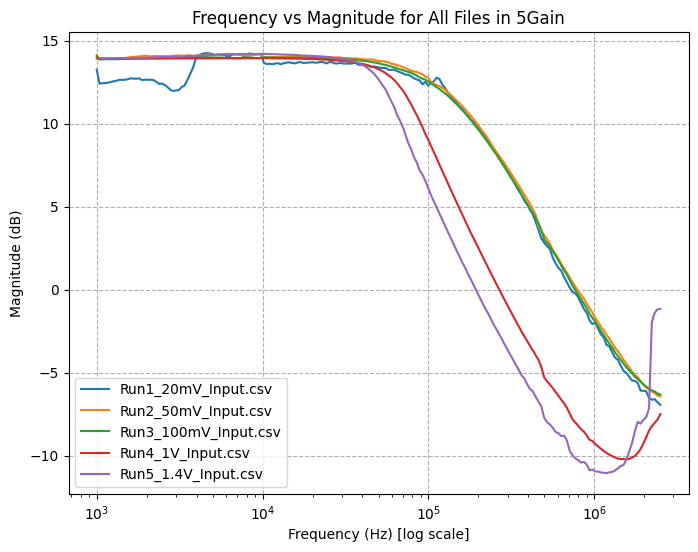

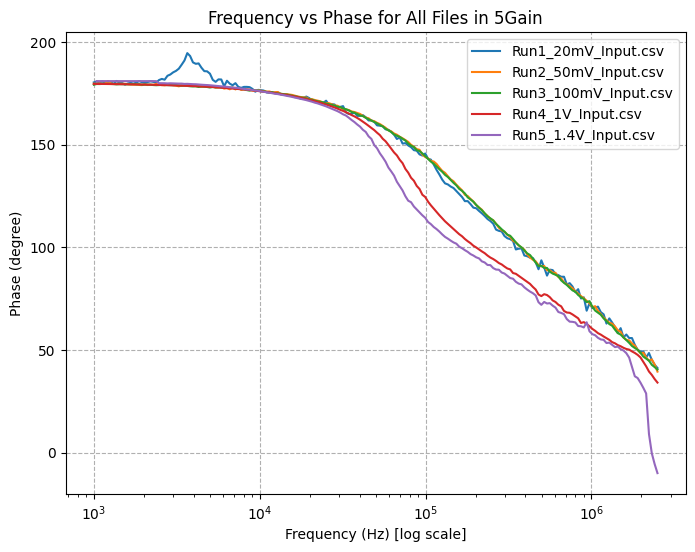

In [584]:
# Pick folder of EB's to plot
source_folder_to_plot = '5Gain'  # Replace with desired folder name
raw = False

plot_all_files_magnitude(combined_df, source_folder_to_plot, raw)
plot_all_files_phase(combined_df, source_folder_to_plot, raw)

In [585]:
class FolderFile:
    def __init__(self, source_folder, source_file):
        self.source_folder = source_folder
        self.source_file = source_file

In [586]:
# Plot Frequency (Hz) vs Magnitude (dB) for selected files
def plot_file_magnitudes(df, folder_files, raw):
    plt.figure(figsize=(8, 6))
    
    # Loop through each file and plot its data
    for folder_file in folder_files:
        plot_data = select_data(df, folder_file.source_folder, folder_file.source_file, raw)
        plt.plot(plot_data['Frequency(Hz)'], plot_data['Magnitude(dB)'], label=f'{folder_file.source_folder}/{folder_file.source_file}')
    
    plt.xscale('log')
    plt.xlabel('Frequency (Hz) [log scale]')
    plt.ylabel('Magnitude (dB)')
    plt.title(f'Frequency vs Magnitude for selected Files')
    plt.grid(True, which="major", ls="--")
    plt.legend()
    plt.show()

In [587]:
# Plot Frequency (Hz) vs Magnitude (dB)
def plot_frequency_vs_magnitude(df, source_folder, source_file, raw):
    plot_data = select_data(df, source_folder, source_file, raw)
    
    plt.figure(figsize=(8, 6))
    
    plt.plot(plot_data['Frequency(Hz)'], plot_data['Magnitude(dB)'], label=f'{source_folder}/{source_file}')
    
    plt.xscale('log')
    plt.xlabel('Frequency (Hz) [log scale]')
    plt.ylabel('Magnitude (dB)')
    plt.title(f'Frequency vs Magnitude for {source_folder}/{source_file}')
    plt.grid(True, which="major", ls="--")
    plt.legend()
    plt.show()

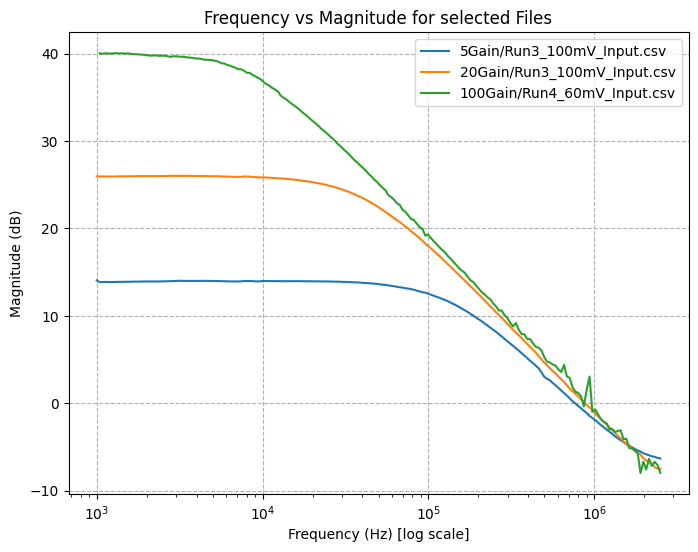

In [588]:
# Pick specific EB's and Inputs to plot
raw = False

plot_file_magnitudes(combined_df, [
    FolderFile('5Gain', 'Run3_100mV_Input.csv'),
    FolderFile('20Gain','Run3_100mV_Input.csv'), 
    FolderFile('100Gain','Run4_60mV_Input.csv')
], raw)

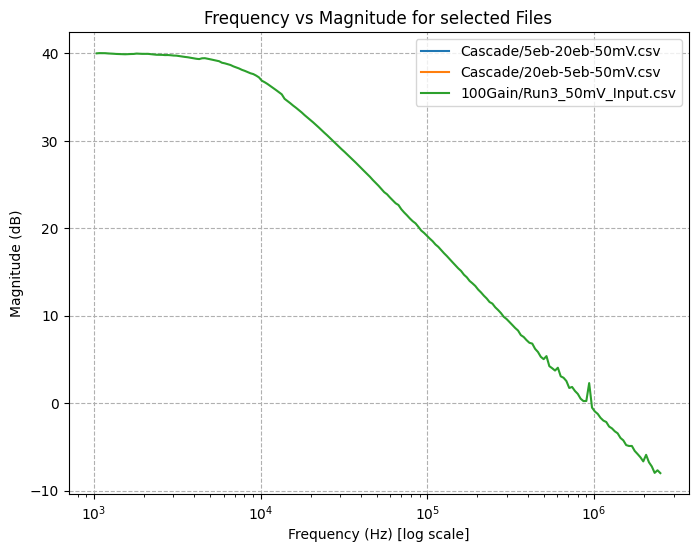

In [589]:
# Pick specific EB's and Inputs to plot
raw = False  # Set to True if you want raw data plotting

plot_file_magnitudes(combined_df, [
    FolderFile('Cascade', '5eb-20eb-50mV.csv'), 
    FolderFile('Cascade', '20eb-5eb-50mV.csv'),
    FolderFile('100Gain', 'Run3_50mV_Input.csv')
], raw)